In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, windows
from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from copy import copy
import time
import glob
import natsort

%matplotlib widget

In [2]:
def read_dat_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = [list(map(float, line.split())) for line in file]
            return np.array(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


def load_data(dir, lw, c, date):
    data_path = './%sS21s_w%s_%s_%s.npy' % (dir, lw, c, date) 
    dark_path = './%sS21_w%s_%s_%s_dark.npy' % (dir, lw, c, date) 
    freqs_path = './%sS21_w%s_%s_%s_freqs.npy' % (dir, lw, c, date) 
    return np.load(data_path), np.load(dark_path), np.load(freqs_path)


def moving_average_filter(x, width):
    y = windows.boxcar(width) / width
    return np.convolve(x, y, mode='same')

def lorentzian(f, f0, Q, S21_min):
    X = (f-f0)/f0
    return (S21_min**2+(2*Q*X)**2)/(1+(2*Q*X)**2)


In [3]:
dir = './mapping_20x20/'
dark_data = read_dat_file(dir + 'Sweep4-6GHz_fine.dat')
dark_s21 = dark_data[:, 1]
dark_freqs = dark_data[:, 0]

s21s, dark, freqs = load_data(dir, 1, 'blue', '12h16_19-10-2023')
M_pxs = 20
N_pxs = 20
nr_scans = s21s.shape[0]
scan_stepsize = 1
px_size = 150
min_sep = px_size / 2
max_sep = px_size * np.sqrt(2)
avg_Q = 2e4
avg_f0 = 5
avg_bw = avg_f0/avg_Q
sep = 1.5*avg_bw


(4.0, 6.0)

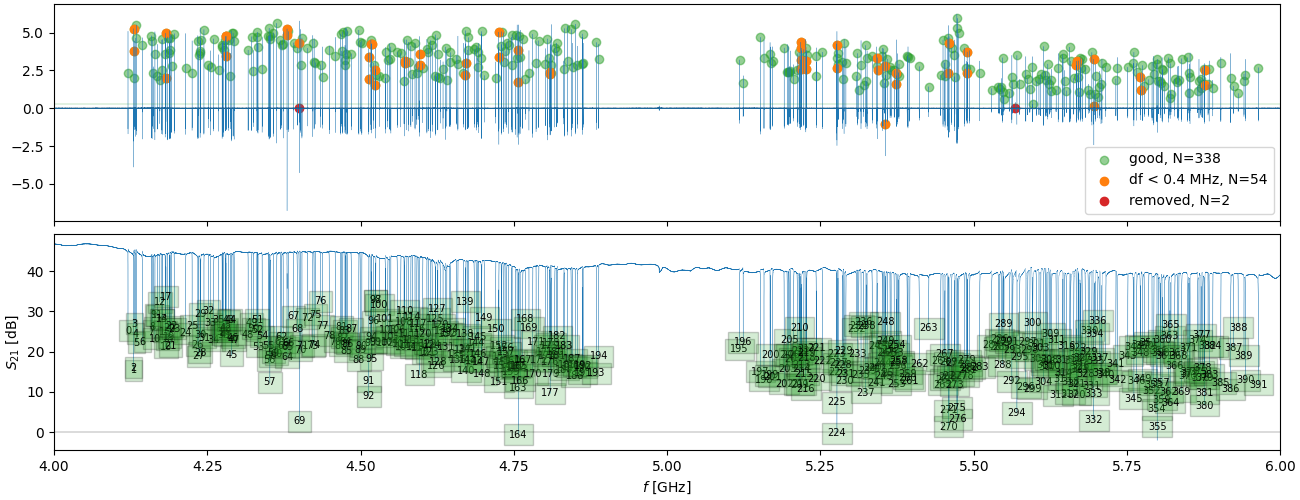

In [4]:
y = dark
width = 2
smoothed_y = moving_average_filter(y, width)
first_diff_y = np.diff(smoothed_y, 1)
smoothed_first_diff_y = moving_average_filter(first_diff_y, width)
sec_diff_y = np.diff(smoothed_first_diff_y, 1)
smoothed_sec_diff_y = moving_average_filter(sec_diff_y, width)
smoothed_freqs = freqs[:-2]

sel = 0.25
pks, props = find_peaks(smoothed_sec_diff_y, height=sel, prominence=sel)
real_pks = []
hs = []
for pk in pks:
    h = y[pk]  
    x = pk 
    new_x = x-1 
    new_h = y[new_x]
    while new_h < h:
        x = new_x
        h = new_h
        new_x -= 1
        new_h = y[new_x]
    real_pks.append(x)
    hs.append(h)
pks = np.array(real_pks)
hs = smoothed_sec_diff_y[real_pks]

freqs_pks = smoothed_freqs[pks]
spacings = freqs_pks[1:] - freqs_pks[:-1]
close = spacings < sep
close = np.hstack((False, close))
too_close = close + np.hstack((close[1:], False))
remove = [69, 295]
removed = pks[remove]
pks = np.delete(pks, remove)
too_close = np.delete(too_close, remove)
close_pks = pks[too_close]

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(13, 5), constrained_layout=True)
ax['a'].plot(smoothed_freqs, smoothed_sec_diff_y, lw=.2)
ax['a'].scatter(smoothed_freqs[pks], smoothed_sec_diff_y[pks], color='tab:green', alpha=0.5, label='good, N=%d' % np.sum(~too_close))
ax['a'].scatter(smoothed_freqs[close_pks], smoothed_sec_diff_y[close_pks], color='tab:orange', label='df < %.1f MHz, N=%d' % (sep*1e3, np.sum(too_close)))
ax['a'].scatter(smoothed_freqs[removed], smoothed_sec_diff_y[remove], color='tab:red', label='removed, N=%d' % len(remove))
ax['a'].axhline(0, 0, 1, color='k', lw=.2)
ax['a'].axhline(sel, 0, 1, color='tab:green', lw=.2)
ax['a'].legend()
for i, label in enumerate(range(len(pks))):
    ax['b'].text(freqs[pks[i]], y[pks[i]], str(label), ha='center', va='center', fontsize=7, bbox=dict(facecolor='tab:green', alpha=0.2))
ax['b'].plot(freqs, y, lw=.2)
# ax['b'].plot(dark_freqs, dark_s21, 'k', lw=0.2)
# # ax['b'].scatter(freqs[pks], y[pks], color='tab:green', alpha=0.5)
ax['b'].axhline(0, 0, 1, color='k', lw=.2)
ax['b'].set_xlabel('$f$ [GHz]')
ax['b'].set_ylabel('$S_{21}$ [dB]')
ax['b'].set_xlim((4, 6))


In [5]:
nr_pks = len(pks)
dark_heights = dark[pks]
height_diffs = np.zeros((nr_scans, nr_scans, nr_pks))
for i in range(nr_scans):
    scanx = s21s[i, 0, :]
    scany = s21s[i, 1, :]
    scanx_heights = scanx[pks]
    scany_heights = scany[pks]
    height_diffx = dark_heights - scanx_heights
    height_diffy = dark_heights - scany_heights
    height_diffs[i, 0, :] = height_diffx
    height_diffs[i, 1, :] = height_diffy

Text(0.5, 0, '$\\it y$ $[dy]$')

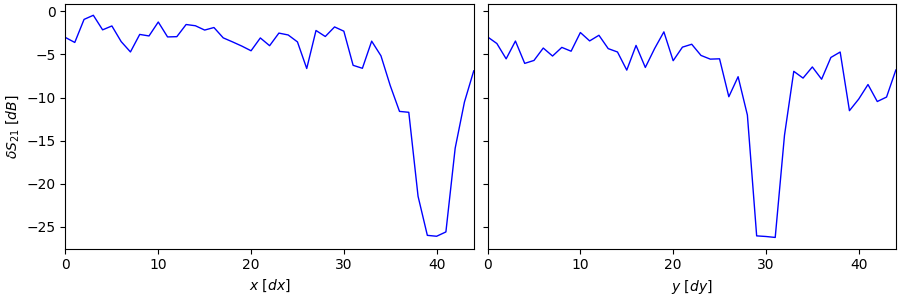

In [6]:
fig, ax = plt.subplot_mosaic('ab', constrained_layout=True, sharex=True, sharey=True, figsize=(9, 3))
id = 2
scans_plot = np.arange(nr_scans)
x_plot = height_diffs[:, 0, id]
y_plot = height_diffs[:, 1, id]
ax['a'].plot(scans_plot, x_plot, c='blue', lw=1)
ax['b'].plot(scans_plot, y_plot, c='blue', lw=1)
ax['a'].set_xlim([0, 44])
ax['a'].set_xticks([0, 10, 20, 30, 40])
ax['a'].set_ylabel('$\it \delta S_{21}$ $[dB]$')
ax['a'].set_xlabel('$\it x$ $[dx]$')
ax['b'].set_xlabel('$\it y$ $[dy]$')
# fig.suptitle('Response KID 9')
# ax['a'].set_title('x-scan')
# ax['b'].set_title('y-scan')
# ax['a'].set_xticks([5, 15, 25, 35, 45], which='minor')
# plt.savefig('Scanxy.svg')

0

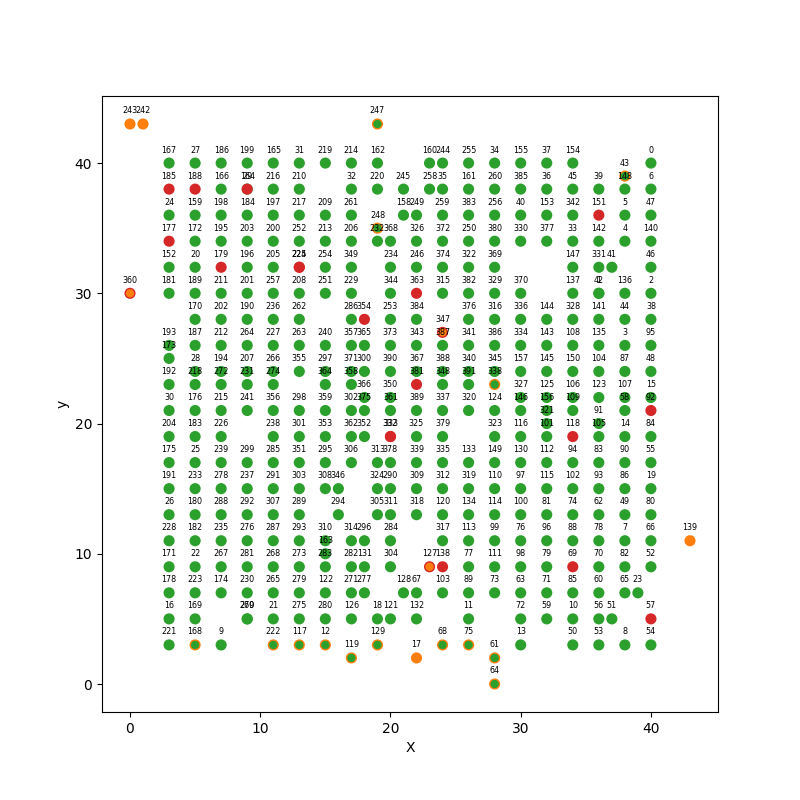

In [7]:
min = np.min(s21s)
max = np.max(s21s)
nr_pks = len(pks)
coords = np.zeros((nr_pks, 3)) 
coords[:, 0] = np.arange(nr_pks)
scan_stepsize = 1
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_box_aspect(1)
ax.grid(False)
height_diffs = resample(height_diffs, nr_scans*scan_stepsize, axis=0)
pos = np.arange(nr_scans*scan_stepsize)
dips = np.arange(nr_pks)
double_pks = np.zeros(nr_pks, dtype=bool)
for i in dips:
    plotx = False
    plot_y = False
    scanx = height_diffs[:, 0, i]
    scany = height_diffs[:, 1, i]
    smoothx = moving_average_filter(scanx, 3)
    smoothy = moving_average_filter(scany, 3)
    diff2x = np.diff(smoothx, 2, prepend=0, append=0)
    diff2y = np.diff(smoothy, 2, prepend=0, append=0)
    diff2x = moving_average_filter(diff2x, 3)
    diff2y = moving_average_filter(diff2y, 3)
    mpp = 2
    mph = 0
    mpw = 0
    xlocs, xprops = find_peaks(diff2x, height=mph, prominence=mpp, width=mpw)
    ylocs, yprops = find_peaks(diff2y, height=mph, prominence=mpp, width=mpw)
    ctrs_x = np.round((xprops['right_ips'] + xprops['left_ips']) / 2)
    ctrs_y = np.round((yprops['right_ips'] + yprops['left_ips']) / 2)
    nr_ctrs_x = len(ctrs_x)
    nr_ctrs_y = len(ctrs_y)
   
    if nr_ctrs_x == 0:
        idxx = np.argmax(diff2x)
        plotx = True
        cx = 'tab:orange'
    elif nr_ctrs_x == 1:
        idxx = int(ctrs_x[0])
        cx = 'tab:green'
        plotx = False
    else:
        xmin = np.argmax(xprops['peak_heights'])
        idxx = int(ctrs_x[xmin])
        plotx = True
        cx = 'tab:red'  
        double_pks[i] = True     

    if nr_ctrs_y == 0:
        idxy = np.argmax(diff2y)
        ploty = True
        cy = 'tab:orange'
    elif nr_ctrs_x == 1:
        idxy = int(ctrs_y[0])
        cy = 'tab:green'
        ploty = False
    else:
        ymin = np.argmax(yprops['peak_heights'])
        idxy = int(ctrs_y[ymin])
        ploty = True
        cy = 'tab:red'  
        double_pks[i] = True   

    coords[i, 1:] = int(idxx), int(idxy)
    ax.scatter(coords[i, 1], coords[i, 2], facecolor='None', edgecolor=str(cy), lw=2)
    ax.scatter(coords[i, 1], coords[i, 2], facecolor=str(cx), edgecolor='None', lw=2)
    text = ax.text(coords[i, 1], coords[i, 2]+1, '%d' % i, ha="center", va="center", color="k", fontsize='xx-small')  

    # if plotx or ploty:
    #     fig2, axes = plt.subplot_mosaic('ab;cd', figsize=(10, 6))
    #     axes['a'].set_title('%d, X' % i, color=str(cx))
    #     axes['b'].set_title('%d, Y' % i, color=str(cy))
    #     axes['a'].plot(pos, scanx, c='tab:blue')
    #     axes['a'].axvline(idxx, 0, 1, ls='--', c='k', lw=.5)
    #     axes['b'].plot(pos, scany, c='tab:blue')
    #     axes['b'].axvline(idxy, 0, 1, ls='--', c='k', lw=.5)
    #     axes['a'].plot(pos, smoothx, lw=.5, c='tab:orange')
    #     axes['b'].plot(pos, smoothy, lw=.5, c='tab:orange')
    #     axes['a'].scatter(pos[idxx], scanx[idxx])
    #     axes['b'].scatter(pos[idxy], scany[idxy])
    #     axes['a'].scatter(pos[xlocs], scanx[xlocs], edgecolor='tab:orange', facecolor='None')
    #     axes['b'].scatter(pos[ylocs], scany[ylocs], edgecolor='tab:orange', facecolor='None')
    #     axes['c'].plot(diff2x)
    #     axes['d'].plot(diff2y)
    #     axes['c'].scatter(pos[idxx], diff2x[idxx])
    #     axes['d'].scatter(pos[idxy], diff2y[idxy])
    #     axes['c'].scatter(pos[idxx], diff2x[idxx])
    #     axes['d'].scatter(pos[idxy], diff2y[idxy])
    #     axes['c'].scatter(pos[xlocs], diff2x[xlocs], edgecolor='tab:orange', facecolor='None')
    #     axes['d'].scatter(pos[ylocs], diff2y[ylocs], edgecolor='tab:orange', facecolor='None')
ax.set_xlabel('X')
ax.set_ylabel('y')
coords.astype(int)
np.sum(~np.any(coords[:, 1:], axis=1))


Unidentified: 
 [[ 69.  34.   9.]
 [338.  28.  23.]]
Before:  [69. 34.  9.]
After:  [69.  0.  0.]


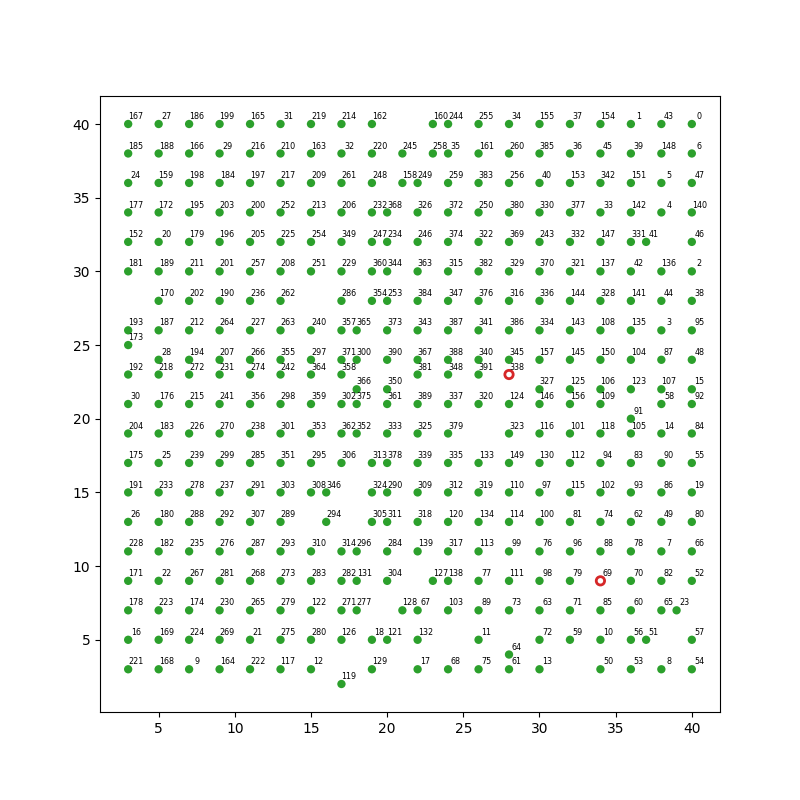

In [8]:
coords_changes = np.array([[1, 36, 40],
                           [17, 22, 3],
                          [43, 38, 40],
                          [61, 28, 3],
                          [64, 28, 4],
                          [69, 0, 0],
                          [139, 22, 11],
                          [163, 15, 38],
                          [164, 9, 3],
                          [224, 7, 5],
                          [242, 13, 23],
                          [243, 30, 32],
                          [247, 19, 32],
                          [248, 19, 36],
                          [270, 9, 19],
                          [321, 32, 30],
                          [332, 32, 32],
                          [338, 0, 0],
                          [347, 24, 28],
                          [354, 19, 28],
                          [360, 19, 30]]
                          )
hidden_pks = coords[[69, 338], :]
print('Unidentified: \n', hidden_pks)
print('Before: ', coords[69])
newcoords = copy(coords)
for i in coords_changes:
    newcoords[i[0], 1:] = i[1:]
print('After: ', newcoords[69])
fig, ax = plt.subplots(figsize=(8, 8))
for coord in newcoords:
    if np.any(coord[1:]):
        ax.scatter(coord[1], coord[2], facecolor='tab:green', edgecolor='None', lw=2)
        text = ax.text(coord[1]+0.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small') 
for coord in hidden_pks:
        ax.scatter(coord[1], coord[2], facecolor='None', edgecolor='tab:red', lw=2)
        text = ax.text(coord[1]+0.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small') 
_ = newcoords.astype(int)

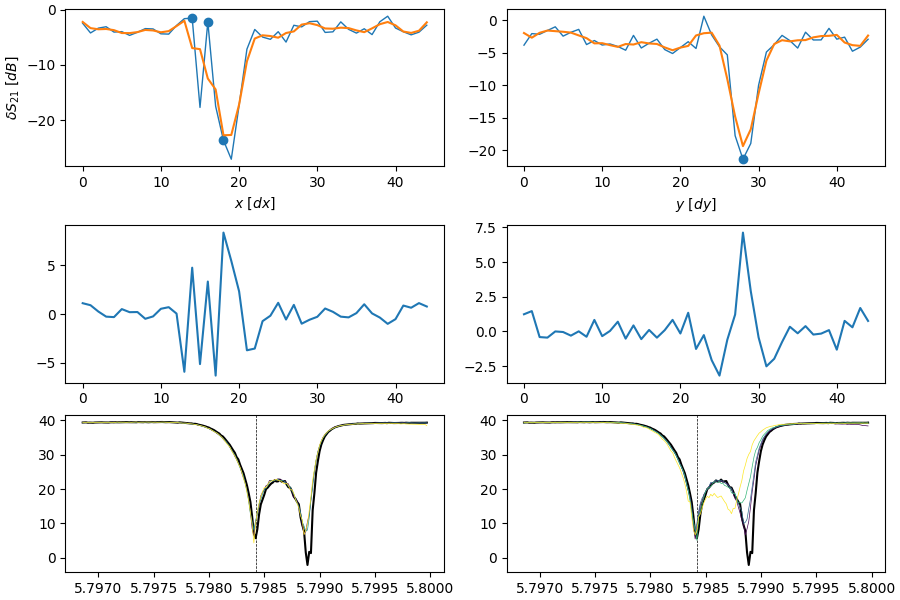

In [9]:
fig.clear()
ax.clear()
fig, ax = plt.subplot_mosaic('ab;cd;ef', constrained_layout=True, sharex=False, sharey=False, figsize=(9, 6))
id = 354
pos_plot = np.arange(nr_scans)
x_plot = height_diffs[:, 0, id]
y_plot = height_diffs[:, 1, id]
smoothx_plot = moving_average_filter(x_plot, 3)
smoothy_plot = moving_average_filter(y_plot, 3)
mpp=3
diff2x_plot = np.diff(smoothx_plot, 2, prepend=0, append=0)
diff2y_plot = np.diff(smoothy_plot, 2, prepend=0, append=0)
xlocs, xprops = find_peaks(diff2x_plot, height=mph, prominence=mpp, width=mpw)
ylocs, yprops = find_peaks(diff2y_plot, height=mph, prominence=mpp, width=mpw)
ax['a'].plot(pos_plot, x_plot, c='tab:blue', lw=1)
ax['a'].plot(pos_plot, smoothx_plot, c='tab:orange')
ax['b'].plot(pos_plot, y_plot, c='tab:blue', lw=1)
ax['b'].plot(pos_plot, smoothy_plot, c='tab:orange')
# ax['a'].set_xlim([0, 44])
# ax['a'].set_xticks([0, 10, 20, 30, 40])
ax['a'].set_ylabel('$\it \delta S_{21}$ $[dB]$')
ax['a'].set_xlabel('$\it x$ $[dx]$')
ax['b'].set_xlabel('$\it y$ $[dy]$')
ax['c'].plot(pos_plot, diff2x_plot)
ax['d'].plot(pos_plot, diff2y_plot)
ax['a'].scatter(pos_plot[xlocs], x_plot[xlocs])
ax['b'].scatter(pos_plot[ylocs], y_plot[ylocs])
floc = pks[id]
bw = 100
ax['e'].plot(freqs[floc-bw:floc+bw], dark[floc-bw:floc+bw], c='k')
ax['f'].plot(freqs[floc-bw:floc+bw], dark[floc-bw:floc+bw], c='k')
ax['e'].axvline(freqs[floc], ls='--', lw=.5, c='k')
ax['f'].axvline(freqs[floc], ls='--', lw=.5, c='k')
idx = np.arange(18, 21)
idy = np.arange(21, 25)
ax['e'].set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(idx))))
ax['f'].set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(idy))))
_ = ax['e'].plot(freqs[floc-bw:floc+bw], s21s[idx, 1, floc-bw:floc+bw].T, lw=.5)
_ = ax['f'].plot(freqs[floc-bw:floc+bw], s21s[idy, 1, floc-bw:floc+bw].T, lw=.5)

In [10]:
spacings[168]

0.004108765105179657

Doubles:  [[ 69.   0.   0.]
 [338.   0.   0.]]


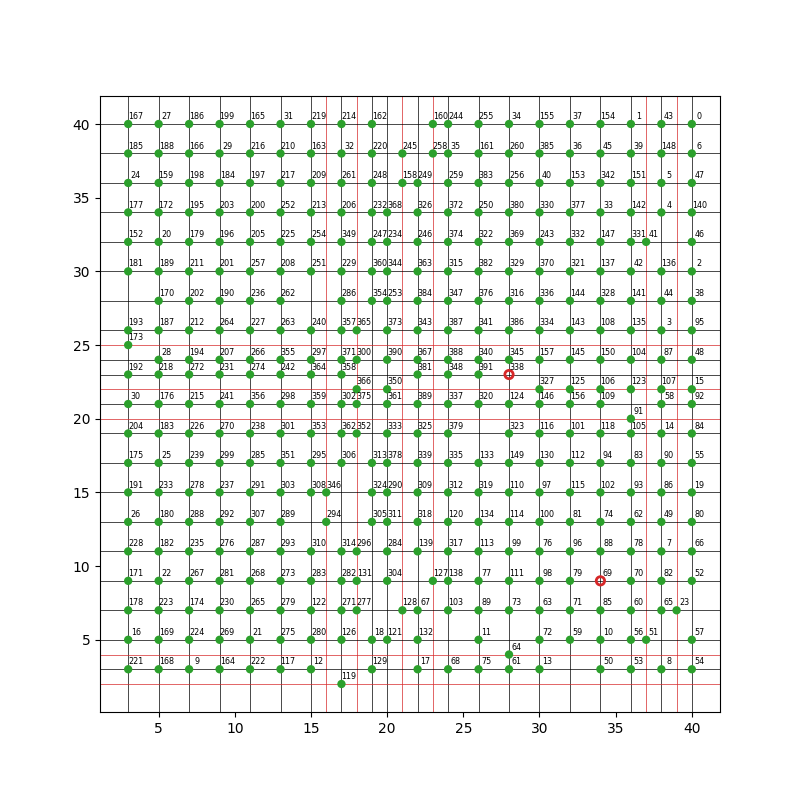

In [11]:
unique, idx_unique, counts = np.unique(newcoords[:, 1:], axis=0, return_index=True, return_counts=True)
double = np.setdiff1d(np.arange(newcoords.shape[0]), idx_unique)
newnewcoords = copy(newcoords)
for i in double:
    dupl = np.where((newcoords[:, 1]==newcoords[i, 1]) & (newcoords[:, 2]==newcoords[i, 2]))[0]
    print('Doubles: ', newcoords[dupl])
    newnewcoords[dupl, 1] = 0
    newnewcoords[dupl, 2] = 0
newcoords.astype(int)
x_edges = []
y_edges = []
cum_nr = 0
min_nr = 10
for i in range(1, nr_scans):
    idxs = newnewcoords[:, 1] == i
    idys = newnewcoords[:, 2] == i
    nrx = np.sum(idxs)
    nry = np.sum(idys)
    if nrx > min_nr:
        x_edges.append(i)
    if nry > min_nr:
        y_edges.append(i)
x_edges = np.array(x_edges)
y_edges = np.array(y_edges)
if len(x_edges) != M_pxs:
    print(' No M_pxs xedges', len(x_edges))
if len(y_edges) != N_pxs:
    print(' No N_pxs yedges', len(y_edges))  

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(M_pxs):
    ax.axvline(x_edges[i], lw=.5, c='k', zorder=0)
for i in range(N_pxs):
    ax.axhline(y_edges[i], lw=.5, c='k', zorder=1)
for coord in newnewcoords:
    if np.any(coord[1:]):
        ax.scatter(coord[1], coord[2], facecolor='tab:green', edgecolor='None', lw=2, zorder=2)
        text = ax.text(coord[1]+.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small', zorder=3)  
for coord in hidden_pks:
        ax.scatter(coord[1], coord[2], facecolor='None', edgecolor='tab:red', lw=2, zorder=2)
        text = ax.text(coord[1]+.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small', zorder=3) 
xbetweens = np.setdiff1d(newnewcoords[:, 1], x_edges)
ybetweens = np.setdiff1d(newnewcoords[:, 2], y_edges)
for i in xbetweens[1:]:
    ax.axvline(i, lw=.5, c='tab:red', zorder=0)
for i in ybetweens[1:]:
    ax.axhline(i, lw=.5, c='tab:red', zorder=1)

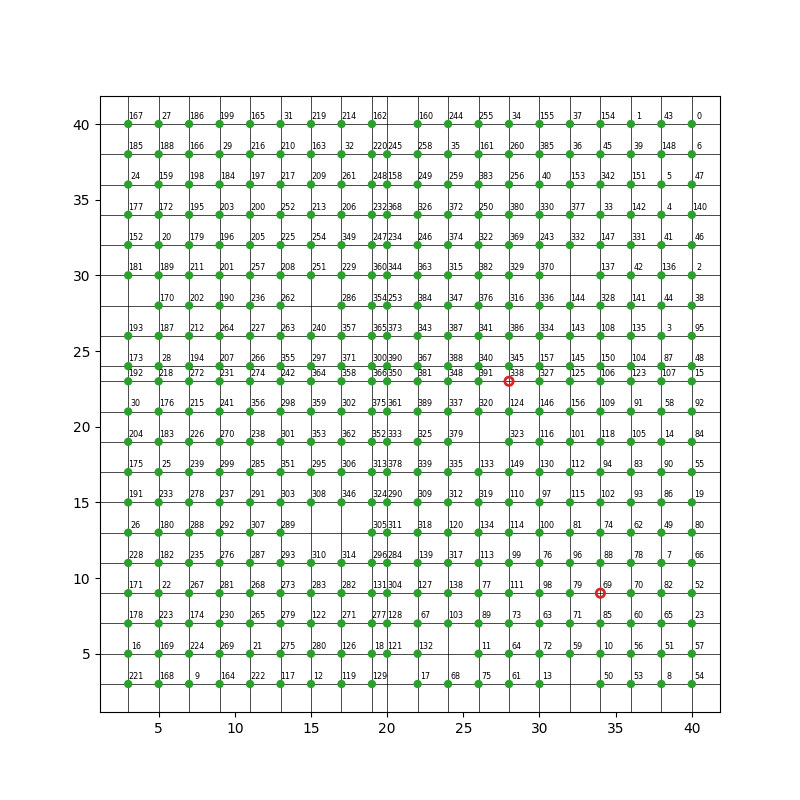

In [12]:
dispx_coords = np.array([[294, 0, 0],
                        [346, 1, 0],
                        [365, 1, 0],
                        [300, 1, 0],
                        [366, 1, 0],
                        [375, 1, 0],
                        [352, 1, 0],
                        [296, 1, 0],
                        [131, 1, 0],
                        [277, 1, 0],
                        [245, -1, 0],
                        [158, -1, 0],
                        [128, -1, 0],
                        [160, -1, 0],
                        [258, -1, 0],
                        [127, -1, 0],
                        [41, 1, 0],
                        [51, 1, 0],
                        [23, 1, 0],
                        ])
dispy_coords = np.array([[119, 0, 1],
                        [64, 0, 1],
                        [321, 0, 0],
                        [91, 0, 1],
                        [366, 0, 1],
                        [350, 0, 1],
                        [327, 0, 1],
                        [125, 0, 1],
                        [106, 0, 1],
                        [123, 0, 1],
                        [107, 0, 1],
                        [15, 0, 1],
                        [173, 0, -1]
                        ])
newnewnewcoords = copy(newnewcoords)
newhidden_pks = copy(hidden_pks)
for i in dispx_coords:
    if np.any(i[1:]):
        newnewnewcoords[i[0], 1:] += i[1:]
    else:
        hidden_pks = np.vstack((newhidden_pks, newnewcoords[i[0]]))
        newnewnewcoords[i[0], 1:] = i[1:]
for i in dispy_coords:
    if np.any(i[1:]):
        newnewnewcoords[i[0], 1:] += i[1:]
    else:
        hidden_pks = np.vstack((newhidden_pks, newnewcoords[i[0]]))
        newnewnewcoords[i[0], 1:] = i[1:]
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(20):
    ax.axvline(x_edges[i], lw=.5, c='k', zorder=0)
    ax.axhline(y_edges[i], lw=.5, c='k', zorder=1)
for coord in newnewnewcoords:
    if np.any(coord[1:]):
        ax.scatter(coord[1], coord[2], facecolor='tab:green', edgecolor='None', lw=2, zorder=2)
        text = ax.text(coord[1]+.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small', zorder=3) 
for coord in newhidden_pks:
        ax.scatter(coord[1], coord[2], facecolor='None', edgecolor='tab:red', lw=2, zorder=2)
        text = ax.text(coord[1]+.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small', zorder=3) 
xbetweens = np.setdiff1d(newnewnewcoords[:, 1], x_edges)
ybetweens = np.setdiff1d(newnewnewcoords[:, 2], y_edges)
for i in xbetweens[1:]:
    ax.axvline(i, lw=.5, c='tab:red', zorder=0)
for i in ybetweens[1:]:
    ax.axhline(i, lw=.5, c='tab:red', zorder=1)

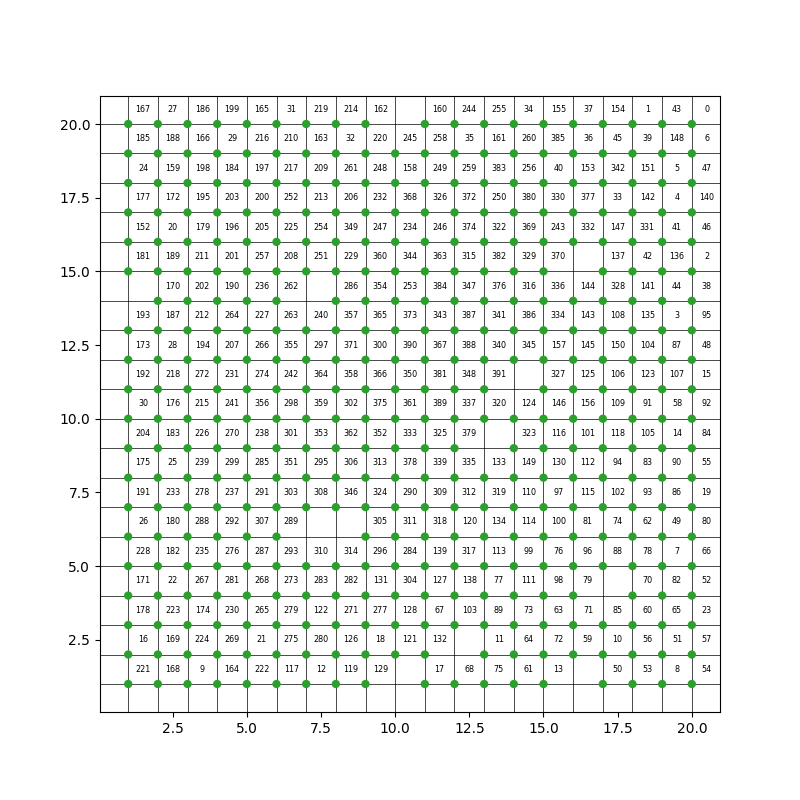

In [13]:
newnewnewnewcoords = copy(newnewnewcoords)
for i, x in enumerate(x_edges):
    newnewnewnewcoords[newnewnewcoords[:, 1] == x, 1] = i+1
for i, y in enumerate(y_edges):
    newnewnewnewcoords[newnewnewcoords[:, 2] == y, 2] = i+1
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(20):
    ax.axvline(i+1, lw=.5, c='k', zorder=0)
    ax.axhline(i+1, lw=.5, c='k', zorder=1)
for coord in newnewnewnewcoords:
    if np.any(coord[1:]):
        ax.scatter(coord[1], coord[2], facecolor='tab:green', edgecolor='None', lw=2, zorder=3)
        text = ax.text(coord[1]+.5, coord[2]+.5, '%d' % coord[0], ha="center", va="center", color="k", fontsize='xx-small',zorder=4)  
coords.astype(int)
kids = np.empty((M_pxs, N_pxs))
kids[:] = np.nan
for coord in newnewnewnewcoords:
    if np.any(coord[1:]):
        kids[int(coord[1]-1), int(coord[2]-1)] = int(coord[0])+1
kids = np.flip(kids, axis=1)
kids = np.flip(kids, axis=0)

In [14]:
kid_id_board = np.load('KID_id_board_400.npy')
mask = (kids == kid_id_board)
nr_tot = (M_pxs*N_pxs)
nr_detected = nr_pks
nr_notswapped = np.sum(mask)
nr_identified = np.sum(~np.isnan(kids))
nr_swapped = nr_identified - nr_notswapped
same = np.argwhere(mask)
# f0s_design = np.load('resonance_freq_SONNET.npy')
f0s_design = np.load('LT295_FAB_f0s.npy')
f0s = freqs[pks]*1e9
f0s_mapped = np.empty(f0s_design.shape)
f0s_mapped[:] = np.nan
df_f = np.empty(kids.shape)
df_f[:] = np.nan
df = np.empty(kids.shape)
df[:] = np.nan
mapped_spacings = np.empty(kids.shape)
mapped_spacings[:] = np.nan
for i in range(M_pxs):
    for j in range(N_pxs):
        design_kid = kid_id_board[i, j]
        design_f0_idx = design_kid - 1
        design_f0 = f0s_design[design_f0_idx]
        mapped_kid = kids[i, j]
        if ~np.isnan(mapped_kid):
            mapped_f0_idx = mapped_kid - 1
            mapped_f0_idx = int(mapped_f0_idx)
            mapped_f0 = f0s[mapped_f0_idx]
            f0s_mapped[design_kid-1] = mapped_f0
            df[i, j] = (design_f0 - mapped_f0)
            df_f[i, j] = df[i, j] / design_f0
            if design_kid > 1:
                prev_design_kid = design_kid - 1
                prev_i, prev_j = np.argwhere(kid_id_board==prev_design_kid)[0]
                prev_mapped_kid = kids[prev_i, prev_j]
                if ~np.isnan(prev_mapped_kid):
                    prev_mapped_f0_idx = prev_mapped_kid - 1
                    prev_mapped_f0_idx = int(prev_mapped_f0_idx)
                    prev_mapped_f0 = f0s[prev_mapped_f0_idx]
                    mapped_spacings[i, j] = mapped_f0 - prev_mapped_f0
std_df_f = np.std(df_f[~np.isnan(df_f)])

(4.0, 6.0)

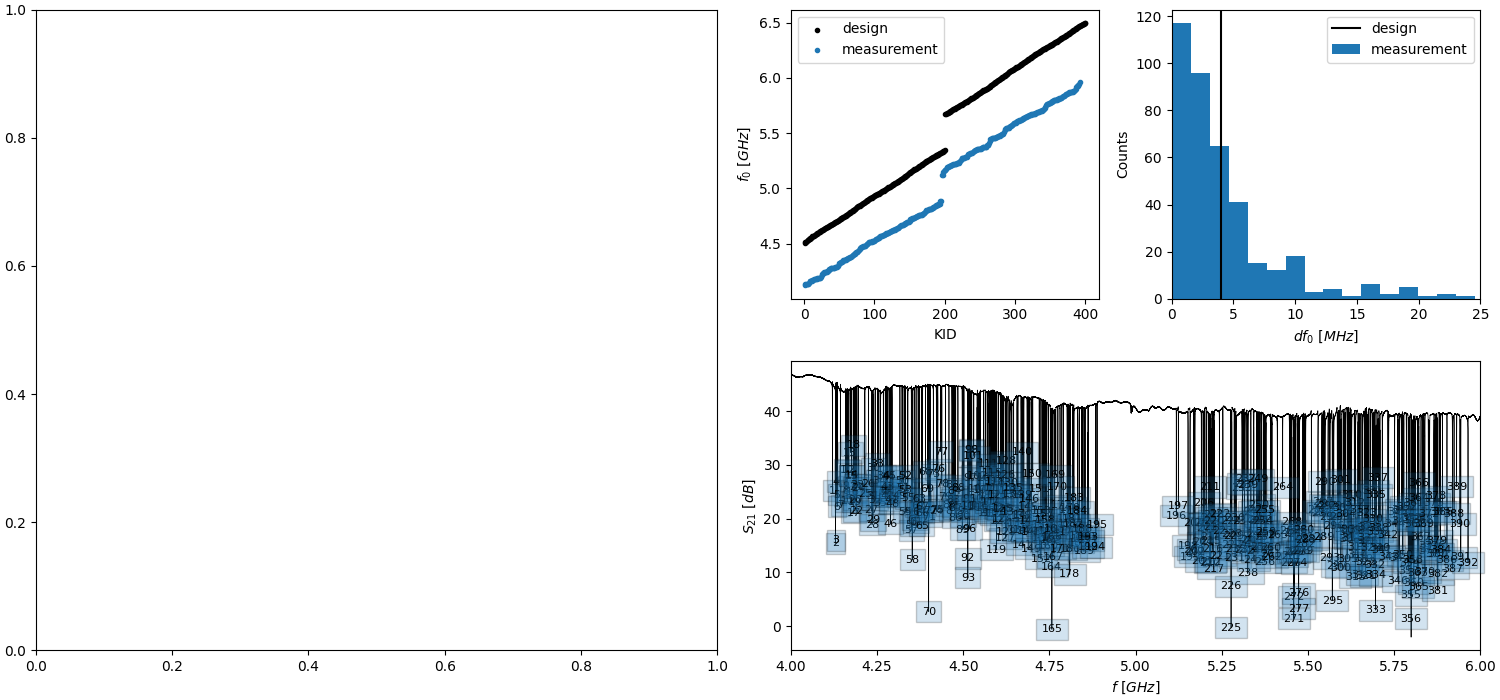

In [15]:
fig, ax = plt.subplot_mosaic('hhed;hhgg', figsize=(15, 7), constrained_layout=True)

##################################
average_spacing_design = 4
spacings = f0s[1:]- f0s[:-1]
_ = ax['d'].axvline(average_spacing_design, color='k', label='design')
_ = ax['d'].hist(spacings*1e-6, bins=150, label='measurement', facecolor='tab:blue')
# ax['d'].set_title('Spacings')
ax['d'].set_xlim(0, 25)
ax['d'].set_xlabel('$d \it{f_0}$ $[MHz]$')
ax['d'].set_ylabel('Counts')
ax['d'].legend()

##################################
ax['e'].scatter(np.arange(nr_tot)+1, f0s_design*1e-9, marker='.', label='design', c='k')
ax['e'].scatter(np.arange(len(f0s))+1, f0s*1e-9, marker='.', label='measurement', color='tab:blue')
ax['e'].set_ylabel('$\it f_0$ $[GHz]$')
ax['e'].set_xlabel('KID')
# ax['e'].set_title('Frequencies')
ax['e'].legend()

##################################
for i, label in enumerate(range(len(pks))):
    ax['g'].text(freqs[pks[i]], dark[pks[i]], str(label+1), ha='center', va='center', fontsize=8, bbox=dict(facecolor='tab:blue', alpha=0.2))
ax['g'].plot(freqs, dark, lw=.5, c='k')
# ax['b'].plot(real_dark_freqs, real_dark, 'k', lw=0.2)
# ax['b'].scatter(freqs[pks], y[pks], color='tab:green', alpha=0.5)
# ax['g'].axhline(0, 0, 1, color='k', lw=.5)
ax['g'].set_xlabel('$\it f$ $[GHz]$')
ax['g'].set_ylabel('$\it S_{21}$ $[dB]$')
ax['g'].set_xlim((4, 6))
# ax['g'].set_title('$S_{21}$')


In [16]:
# plt.savefig('C:/Users\wilbertr\OneDrive\TU Delft\PhD\Graduate School\GONOGO\LT295.svg')

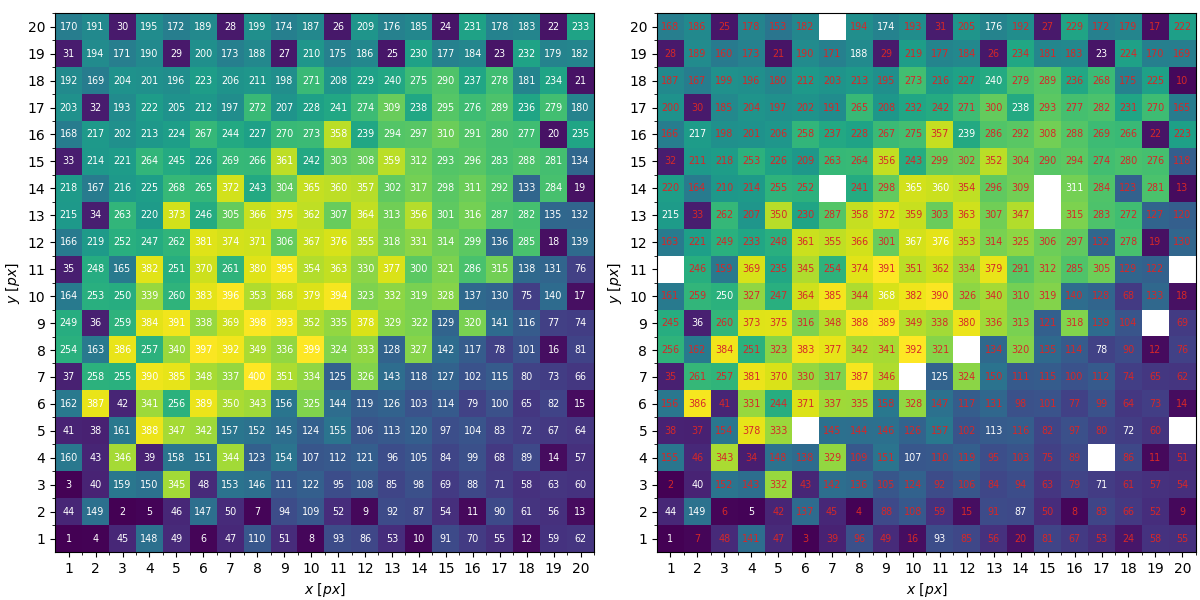

In [17]:
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 6), constrained_layout=True)

############################
ax['a'].imshow(kids, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kids[i, j]
        if ~np.isnan(idx):
            if mask[i, j]:
                color = 'w'
            else:
                color = 'tab:red'
            text = ax['a'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['a'].set_xticks(np.arange(0, M_pxs, 1));
ax['a'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['a'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['a'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['a'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['a'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['a'].set_xlabel('$\it x$ $[px]$')
ax['a'].set_ylabel('$\it y$ $[px]$')
# ax['a'].set_title("Measurement")
# grid
ax['a'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['a'].grid(False, which='major')

############################
im = ax['b'].imshow(kid_id_board, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kid_id_board[i, j]
        if ~np.isnan(idx):
            text = ax['b'].text(j, i, '%d' % idx, ha="center", va="center", color="w", fontsize='x-small')   
# Major ticks
ax['b'].set_xticks(np.arange(0, M_pxs, 1));
ax['b'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['b'].set_xlabel('$\it x$ $[px]$')
ax['b'].set_ylabel('$\it y$ $[px]$')
# ax['b'].set_title("Design")
# grid
ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['b'].grid(False, which='major')
# cbar = fig.colorbar(im, ax=ax['b'])
# # cbar.ax.invert_yaxis()
# cbar.ax.set_ylabel('$f_0$ $[GHz]$')




In [18]:
spacings[279]

1499777.3767957687

# detected: 392/400
# identified: 388/392
# swapped: 358/388 
Unidentified: 
 [[ 69.  34.   9.]
 [338.  28.  23.]]


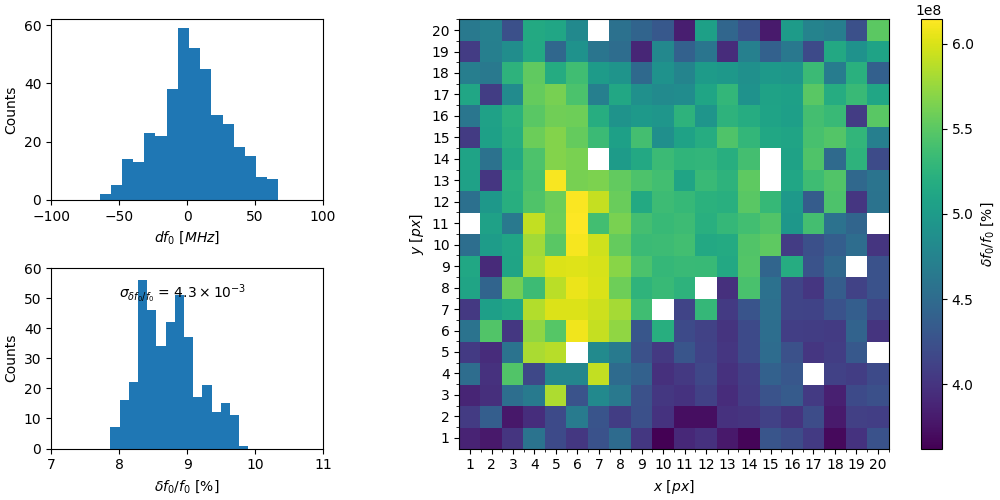

In [19]:
fig, ax = plt.subplot_mosaic('hcc;fcc', figsize=(10, 5), constrained_layout=True)

###################################
# ax['h'].hist(spacings*1e-6, bins=50, alpha=.8, label='before')
ax['h'].hist(mapped_spacings.flatten()*1e-6, bins=40, alpha=1, label='after')
ax['h'].set_xlim([-100, 100])
# ax['h'].set_ylim([0, 50])
ax['h'].set_xlabel('$d\it{f_0}$ $[MHz]$')
ax['h'].set_ylabel('Counts')

###################################
ax['f'].hist((df_f.flatten()*100), bins=15)
ax['f'].text(8, 50, "$\it\sigma_{\delta f_0/f_0}$ = $%.1f \\times 10^{-3}$" % (std_df_f*1e3))
ax['f'].set_xlim((7, 11))
ax['f'].set_xlabel('$\it \delta f_0/f_0$ [%]')
ax['f'].set_ylabel('Counts')
ax['f'].set_ylim([0, 60])
# ax['f'].set_title("Frequency scatter, $\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# ax['f'].legend()
print('# detected: %d/%d\n# identified: %d/%d\n# swapped: %d/%d ' % (nr_detected, nr_tot, nr_identified, nr_detected, nr_swapped, nr_identified))

###################################
im = ax['c'].imshow(df, origin='lower', cmap='viridis')
# for i in range(M_pxs):
#     for j in range(N_pxs):
#         idx = kids[i, j]
#         if ~np.isnan(idx):
#             if mask[i, j]:
#                 color = 'w'
#             else:
#                 color = 'tab:red'
#             text = ax['c'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['c'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['c'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
# ax['c'].set_title("$\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# grid
ax['c'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['c'].grid(False, which='major')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it \delta f_0/f_0$ [%]')
print('Unidentified: \n', newhidden_pks)
# plt.savefig('scatter.svg')

In [20]:
print(np.argwhere((np.absolute(spacings)<.5e6)&(np.absolute(spacings)>.47e6)))
print(spacings[(np.absolute(spacings)<.5e6)&(np.absolute(spacings)>.47e6)])

[[266]
 [354]
 [357]]
[499925.79226589 499925.79226494 484303.11125755]


In [21]:
spacings[363]

468680.4302492142

line


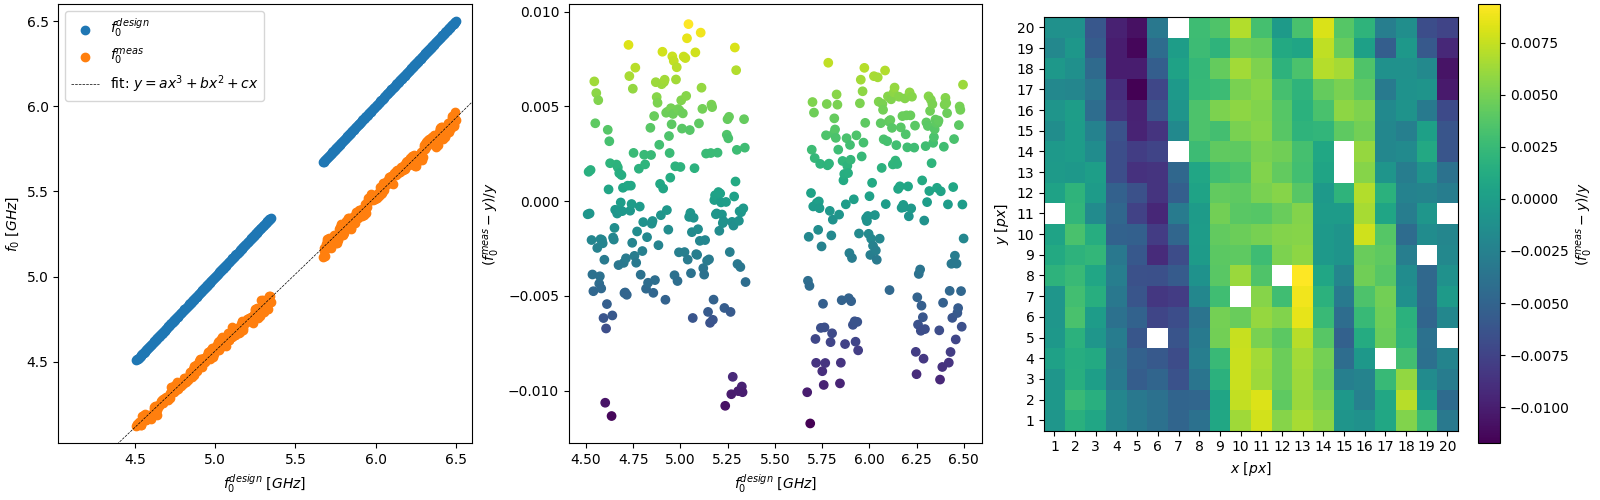

In [22]:
def linear(x, a):
    return a*x

def secorder(x, a, b, c):
    return a*x**2+b*x

def thirdorder(x, a, b, c):
    return a*x**3+b*x**2+c*x


ids = np.arange(400)
nans = np.isnan(f0s_mapped)

line = thirdorder
flim = np.array([np.amin((f0s_design[~nans], f0s_mapped[~nans]))-.1e9, np.amax((f0s_design[~nans], f0s_mapped[~nans]))+.1e9])
if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    elif line == thirdorder:
        eq = 'y=ax^3+bx^2+cx'
        save = 'fit_thirdorder'
    print('line')
    popt, pcov = curve_fit(line, f0s_design[~nans], f0s_mapped[~nans])
    fit = line(f0s_design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = f0s_design
    label = 'f_0^{design}'
    save = 'nofit'

corr_df = (f0s_mapped-fit)
corr_df_f = corr_df / fit
corr_df_map = np.empty(kids.shape)
corr_df_map[:] = np.nan
corr_df_f_map = np.empty(kids.shape)
corr_df_f_map[:] = np.nan
for i, val in enumerate(corr_df):
    x, y = np.argwhere(kid_id_board==i+1)[0]
    corr_df_map[x, y] = val
    corr_df_f_map[x, y] = corr_df_f[i]

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(f0s_design*1e-9, f0s_design*1e-9, label='$\it f_0^{design}$')
ax['a'].scatter(f0s_design*1e-9, f0s_mapped*1e-9, label='$\it f_0^{meas}$')
if line:
    ax['a'].plot(xfit*1e-9, yfit*1e-9, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim*1e-9)
ax['a'].set_ylim(flim*1e-9)
ax['a'].legend(loc='upper left')
ax['b'].scatter(f0s_design*1e-9, corr_df_f, label='residual, $f_0-y_2$', c=corr_df_f)
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(corr_df_f_map, origin='lower', cmap='viridis')
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# ax['c'].set_ylim([-100, 50])
# plt.savefig('LT295chip3_scatter_'+save)

In [26]:
def map(axis):
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i in range(M_pxs):
            for j in range(N_pxs):
                id = kids[i, j]-1
                if ~np.isnan(id):
                    maps[i, j, nr] = height_diffs[nr, axis, int(id)]
                else:
                    maps[i, j, nr] = np.nan
    return maps
mapsx = map(0)
mapsy = map(1) 

In [27]:
def update_map(frame):
    nr_scans = 45
    if frame < nr_scans:
        im = ax['b'].imshow(mapsx[:, :, frame], origin='lower', cmap='viridis', vmin=-20, vmax=20)
        ax['b'].set_title('x=%d, y=%d' % (frame, 0))
    else:
        frame -= nr_scans
        im = ax['b'].imshow(mapsy[:, :, frame], origin='lower', cmap='viridis', vmin=-20, vmax=20)
        ax['b'].set_title('x=%d, y=%d' % (0, frame))
    ax['b'].set_xticks(np.arange(0, M_pxs, 1));
    ax['b'].set_yticks(np.arange(0, N_pxs, 1));
    # Labels for major ticks
    ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
    ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
    # Minor ticks
    ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
    ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
    # labels
    ax['b'].set_xlabel('$\it x$ $[px]$')
    ax['b'].set_ylabel('$\it y$ $[px]$')
    
    ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
    ax['b'].grid(False, which='major')


In [28]:
# fig, ax = plt.subplot_mosaic('b', constrained_layout=True, figsize=(4, 4))
# ax['b'].set_xticks(np.arange(0, M_pxs, 1));
# ax['b'].set_yticks(np.arange(0, N_pxs, 1));
# # Labels for major ticks
# ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
# ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# # Minor ticks
# ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
# ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# # labels
# ax['b'].set_xlabel('$\it x$ $[px]$')
# ax['b'].set_ylabel('$\it y$ $[px]$')

# ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
# ax['b'].grid(False, which='major')
# animation = FuncAnimation(fig, update_map, frames=90, interval=100)  # 10 frames, 500 milliseconds interval
# animation.save('mapping.gif', writer='pillow')  # Requires ImageMagick to be installed

In [29]:
def update_s21(frame, id, bw):
    ax['a'].cla()
    ax['b'].cla()
    ax['e'].cla()
    ax['f'].cla()
    floc = pks[id]
    nr_scans = 45
    pos_plot = np.arange(nr_scans)
    ax['e'].set_title('x=%d' % (frame))
    ax['f'].set_title('y=%d' % (frame))
    x_plot = height_diffs[:, 0, id]
    y_plot = height_diffs[:, 1, id]
    ax['a'].plot(pos_plot, x_plot, c='tab:blue', lw=1)
    ax['b'].plot(pos_plot, y_plot, c='tab:blue', lw=1)
    ax['a'].scatter(frame, x_plot[frame], facecolor='tab:orange')
    ax['b'].scatter(frame, y_plot[frame], facecolor='tab:orange')
    dark_s21 = dark[floc-bw:floc+bw]
    ax['e'].plot(freqs[floc-bw:floc+bw], dark_s21, c='k', zorder=0, lw=1)
    ax['f'].plot(freqs[floc-bw:floc+bw], dark_s21, c='k', zorder=0, lw=1)
    ax['e'].axvline(freqs[floc], ls='--', lw=.5, c='k')
    ax['f'].axvline(freqs[floc], ls='--', lw=.5, c='k')
    s21_x = s21s[frame, 0, floc-bw:floc+bw].T
    s21_y = s21s[frame, 1, floc-bw:floc+bw].T
    _ = ax['e'].plot(freqs[floc-bw:floc+bw], s21_x, lw=2, c='tab:orange', zorder=1)
    _ = ax['f'].plot(freqs[floc-bw:floc+bw], s21_y, lw=2, c='tab:orange', zorder=1)
    ax['e'].scatter(freqs[floc], s21_x[bw], facecolor='tab:orange')
    ax['f'].scatter(freqs[floc], s21_y[bw], facecolor='tab:orange')
    ax['e'].scatter(freqs[floc], dark_s21[bw], facecolor='k')
    ax['f'].scatter(freqs[floc], dark_s21[bw], facecolor='k')
    ax['a'].set_ylabel('$\it \delta S_{21}$ $[dB]$')
    ax['b'].set_ylabel('$\it \delta S_{21}$ $[dB]$')
    ax['a'].set_xlabel('$\it x$ $[dx]$')
    ax['b'].set_xlabel('$\it y$ $[dy]$')
    ax['e'].set_ylabel('$\it S_{21}$ $[dB]$')
    ax['f'].set_ylabel('$\it S_{21}$ $[dB]$')
    ax['e'].set_xlabel('$\it f$ $[GHz]$')
    ax['f'].set_xlabel('$\it f$ $[Ghz]$')

In [ ]:
fig2, ax = plt.subplot_mosaic('ef;ab', constrained_layout=True, sharex=False, sharey=False, figsize=(9, 6))
id = 168
bw= 100
animation = FuncAnimation(fig2, update_s21, frames=45, interval=100, fargs=(id, bw))  # 10 frames, 500 milliseconds interval
animation.save('s21_KID'+str(id)+'.gif', writer='pillow')  # Requires ImageMagick to be installed